<a href="https://colab.research.google.com/github/ostwind/experiments/blob/master/scatter_wavelet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install torch
!pip install kymatio

# I/O
import os
import scipy.io.wavfile

# scatter transform computation
import torch
from kymatio import Scattering1D
from kymatio.datasets import fetch_fsdd
import numpy as np

# visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# downstream classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

def preprocess(x):
    # normalize raw numpy array then convert it to torch tensor
    x = x.astype(float)
    x /= np.abs( x ).max()
    x = x.reshape(1, -1)
    x = torch.from_numpy(x).float()
    return x

# wavelet dictionary parameters
# article experiment accuracy is achieved with Q = 100, takes a long time! 
J = 6
Q = 100

# to retrieve order 2 coefficients, we call
# compute_meta_scattering() for order 2 indices
meta = Scattering1D.compute_meta_scattering(J, Q)
order0_indices = (meta['order'] == 0)
order1_indices = (meta['order'] == 1)
order2_indices = (meta['order'] == 2)

def scatter_transform(audio, padding = 100):
    # define the scattering convolution network
    T = audio.shape[-1]
    scattering = Scattering1D(J, T, Q)
    
    # compute the 0, 1st and 2nd order coefficients  
    coeffs = scattering.forward(audio)
    order2_coeffs = coeffs[0,order2_indices,:].numpy()
    
    if padding:
        padded_coeffs = np.zeros( (order2_coeffs.shape[0], padding) )
        padded_coeffs[:, :order2_coeffs.shape[1]] = order2_coeffs
        return padded_coeffs
    else:
        return coeffs # if not padded, return all coefs for viz

load, preprocess and apply scatter wavelets to data. This may take a while (>20 mins) for most laptops.  

In [13]:
# load FSDD data and collect labels, scatter coefficientss 
info_dataset = fetch_fsdd(verbose=True)
labels = []
scatter_coeffs = []

for data_ind in range(len(info_dataset['files'])): 
    file_path = os.path.join(info_dataset['path_dataset'],
                        sorted(info_dataset['files'])[data_ind])
    _, audio_raw = scipy.io.wavfile.read(file_path)
    
    # to ensure uniform length, drop coefficients that are too long
    if len(audio_raw) > 5500:
        continue
    
    audio = preprocess(audio_raw)
    padded_coeffs = scatter_transform(audio) 
    
    if not data_ind:
        print('first scatter representation has {} wavelets and {} padded length'.format(\
            padded_coeffs.shape[0], padded_coeffs.shape[1]) )
    
    labels.append(file_path.split('/')[-1].split('_')[0])
    scatter_coeffs.append( padded_coeffs )

# collapse the coefficients into a long vector 
# scatter_coeffs_array has shape [num_samples, num_coeffs]
scatter_coeffs_array = np.array([ r.reshape(-1) for r in scatter_coeffs])
labels = np.array([int(l) for l in labels])

first scatter representation has 441 wavelets and 100 padded length


Make a 2D t-SNE projection of the scatter coefficients 

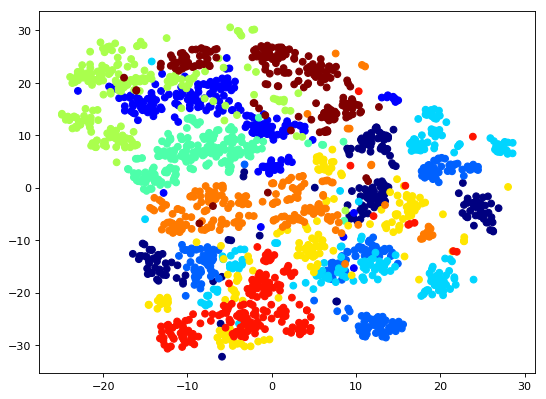

In [15]:
# project coefficients down to 2D using t-SNE and plot
coeffs_embedded = TSNE(n_components=2, perplexity=90).fit_transform(scatter_coeffs_array)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(coeffs_embedded[:, 0], coeffs_embedded[:, 1], label = labels, c= labels, cmap='jet')
plt.show()

3-fold classification on nearly the entire dataset

In [16]:
X = scatter_coeffs_array
y = labels 

# start k-fold validation, collect accuracies per fold
k = 3
kf = KFold(n_splits=k, shuffle=True)
accs = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train, y_train)
    accs.append( neigh.score( X_test, y_test ) )

print('{} fold accuracy with training set shape {} is {} '.format(\
    k, X_train.shape, np.mean(accs)))
print('to recreate articles reported performance, set Q=100')

3 fold accuracy with training set shape (1304, 44100) is 0.9100204498977504 
to recreate articles reported performance, set Q=100


extreme classification scenario where we use 20 samples to classify rest of the dataset, 1-nearest neighbor

In [21]:
# to build the 20-sample training set, for each digit, 
# I picked observation indices belonging to first 2 speakers 
train_indices = [0,80,225,287, 425,487,625,687,830,881,1030,1091,1230,1281,1480,1431,1680,1631,1880,1831]

# no need to choose test indices, use rest of the dataset as held-out set
test_indices = [a for a in range(len(X)) if a not in train_indices]
#test_indices = [120, 280, 486, 686, 882,1082,1282,1492,1682,1860]

X_train_20 = X[ train_indices ]
X_test_20 = X[test_indices ]
y_train_20 = y[train_indices]
y_test_20 = y[test_indices]

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train_20, y_train_20)
print(neigh.score(X_test_20, y_test_20))

0.49018595041322316


There's one more plot that compares a sample's scatter representation with the scatter representation of its sine distorted version.

(-0.5, 80.5, 440.5, -0.5)

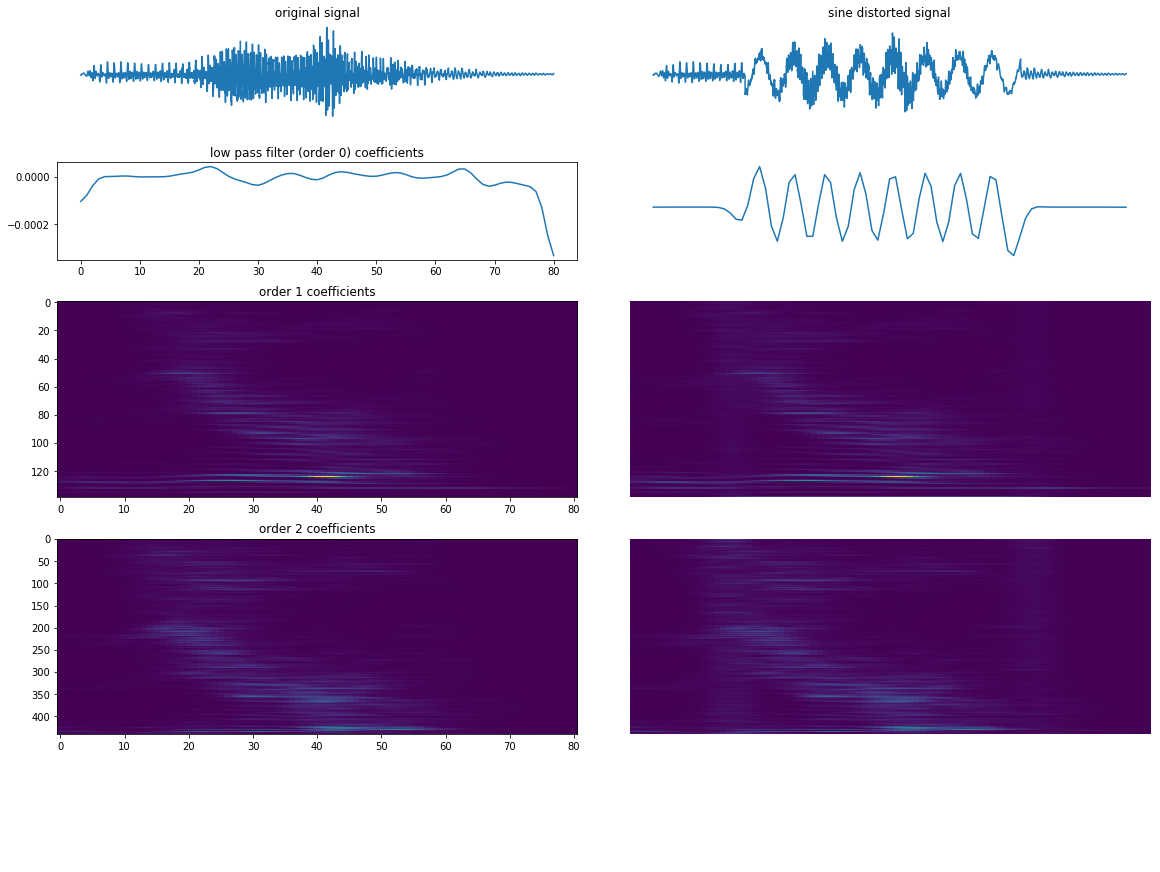

In [31]:
# fetch Jackson saying '0'
file_path = os.path.join(info_dataset['path_dataset'],
                        sorted(info_dataset['files'])[0])
_, audio_raw = scipy.io.wavfile.read(file_path)
audio = preprocess(audio_raw)

# scatter transform audio 
Sx = scatter_transform(audio, padding = 0)

x_distorted = np.copy(audio.numpy())
corruptor = 0.4*np.sin( (np.linspace(1000, 4000, 3000)*np.pi/180).reshape(1, -1) )
x_distorted[:, 1000:4000] = (0.6*audio[:, 1000:4000].numpy()) + corruptor
x_distorted = torch.from_numpy(x_distorted).float()

# compute coeffs of distorted signal
Sx_distorted = scatter_transform(x_distorted, padding = 0) 

import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = gridspec.GridSpec(7, 2, figure=fig)#, width_ratios=[1, 1, 3, 3])
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(audio[0,:].numpy())
ax2.axis('off')
ax2.title.set_text('original signal')

ax3 = fig.add_subplot(gs[0, 1], sharex=ax2, sharey=ax2)
ax3.plot(x_distorted[0,:].numpy())
ax3.axis('off')
ax3.title.set_text('sine distorted signal')

#############################
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(Sx[0,order0_indices,:].numpy().ravel())
ax4.title.set_text('low pass filter (order 0) coefficients')

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(Sx_distorted[0,order0_indices,:].numpy().ravel())
ax5.axis('off')
#############################

#############################
ax6 = fig.add_subplot(gs[2:4, 0])
ax6.imshow(Sx[0,order1_indices,:].numpy(), aspect='auto')
ax6.title.set_text('order 1 coefficients')

ax7 = fig.add_subplot(gs[2:4, 1])
ax7.imshow(Sx_distorted[0,order1_indices,:].numpy(), aspect='auto')
ax7.axis('off')
#############################

#############################
ax8 = fig.add_subplot(gs[4:6, 0])
ax8.imshow(Sx[0,order2_indices,:].numpy(), aspect='auto')
ax8.title.set_text('order 2 coefficients')

ax9 = fig.add_subplot(gs[4:6, 1])
ax9.imshow(Sx_distorted[0,order2_indices,:].numpy(), aspect='auto')
ax9.axis('off')
#############################